In [22]:
import os
import PIL
import scipy.stats
import numpy as np
import nibabel as nib
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from skimage.morphology import erosion
from dipy.core.gradients import gradient_table
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [23]:
# Fit the signal models to phantom and volunteer data

#os.system('python cumulant.py')
#os.system('python higher_order.py')
#os.system('python gamma.py')
#os.system('python qti.py')

In [24]:
# Define plotting parameters

plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 8})
label_font_size = 12
one_column = 3.54
one_half_column = 5.51
two_column = 7.48
dpi = 500

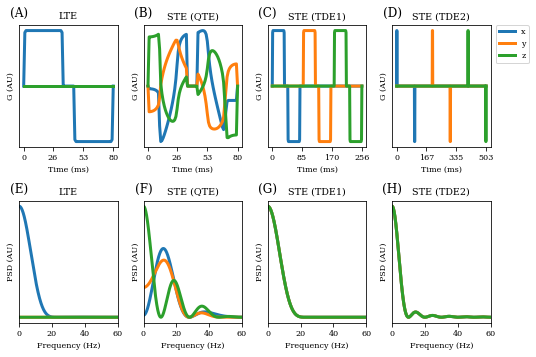

In [25]:
# Create the gradient waveform figure

plt.rcParams['font.family'] = 'serif'

def calc_power(waveform, T, N=int(1e5)):
    """Calculate the power spectrum of a gradient waveform."""
    q = np.cumsum(waveform)
    dt = T / (len(q) - 1)
    ps = np.abs(np.fft.fft(q, N))**2
    freqs = np.fft.fftfreq(N, dt)
    idx = np.argsort(freqs)
    return ps[idx], freqs[idx]

ste = np.loadtxt('../Preproc-data/waveform_STE.txt')
lte = np.loadtxt('../Preproc-data/waveform_LTE.txt')
T = 80e-3
t = np.linspace(0, T * 1e3, lte.shape[0])

n_zeros = 8
tde_1 = np.zeros((lte.shape[0] * 3 + n_zeros * 2, 3))
tde_1[0:78, 0] = lte[:, 0]
tde_1[78 + n_zeros:78 + n_zeros + 78, 1] = lte[:, 0]
tde_1[78 + n_zeros + 78 + n_zeros::, 2] = lte[:, 0]
tde_1_T = 256e-3
tde_1_t = np.linspace(0, tde_1_T * 1e3, tde_1.shape[0])

tde_2 = np.zeros((504, 3))
tde_2[1:3, 0] = 1
tde_2[101:103, 0] = -1
tde_2[201:203, 1] = 1
tde_2[301:303, 1] = -1
tde_2[401:403, 2] = 1
tde_2[501:503, 2] = -1
tde_2_T = 503e-3
tde_2_t = np.linspace(0, tde_2_T * 1e3, tde_2.shape[0])

fig, ax = plt.subplots(2, 4, figsize=(two_column, 5))
for i in range(3):
    ax[0, 0].plot(t, lte[:, i], lw=3)
    ax[0, 1].plot(t, ste[:, i], lw=3)
    ax[0, 2].plot(tde_1_t, tde_1[:, i], lw=3)
    ax[0, 3].plot(tde_2_t, tde_2[:, i], lw=3)
    ps, freqs = calc_power(lte[:, i], T)
    ax[1, 0].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(ste[:, i], T)
    ax[1, 1].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_1[:, 1], tde_1_T)
    ax[1, 2].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_2[:, 1], tde_2_T)
    ax[1, 3].plot(freqs, ps, lw=3)
titles = ['LTE', 'STE (QTE)', 'STE (TDE1)', 'STE (TDE2)']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)']
for i in range(4):
    for j in range(2):
        ax[j, i].set_title(titles[i])
        k = j * 4 + i
        ax[j, i].text(-0.0, 1.04, labels[k], verticalalignment='bottom',
                      horizontalalignment='center', fontsize=label_font_size,
                      color='black', transform=ax[j, i].transAxes)
        ax[j, i].set_yticks([])
    ax[0, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('G (AU)')
    ax[1, i].set_xlabel('Frequency (Hz)')
    ax[1, i].set_ylabel('PSD (AU)')
    ax[1, i].set_xlim([0, 60])       
    ax[1, i].set_xticks(np.linspace(0, 60, 4).astype(int))
ax[0, 3].legend(['x', 'y', 'z'], bbox_to_anchor=(1.05, 1),
             loc='upper left', borderaxespad=0.)
ax[0, 0].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 1].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 2].set_xticks(np.linspace(0, tde_1_T * 1e3, 4).astype(int))
ax[0, 3].set_xticks(np.linspace(0, tde_2_T * 1e3, 4).astype(int))
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/waveforms.pdf', dpi=dpi)

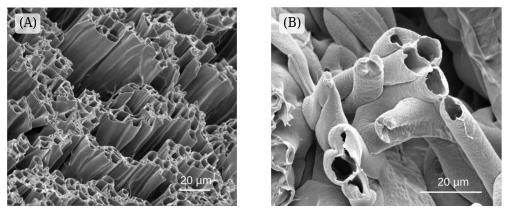

In [26]:
# Create the phantom figure

img_1 = np.array(PIL.Image.open('../LaTeX/Figures/parallel_fibres.png'))
img_2 = np.array(PIL.Image.open('../LaTeX/Figures/random_fibres.png'))

fig, ax = plt.subplots(1, 2, figsize=(two_column, 3))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
for i, l in enumerate(['(A)', '(B)']):
    ax[i].axis('off')
    ax[i].text(.05, .95, l, verticalalignment='top',
               horizontalalignment='left', fontsize=label_font_size,
               color='black', transform=ax[i].transAxes,
               bbox=dict(boxstyle='round', fc='white', ec='none', alpha=.75))
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/phantom_sem.pdf', dpi=dpi)

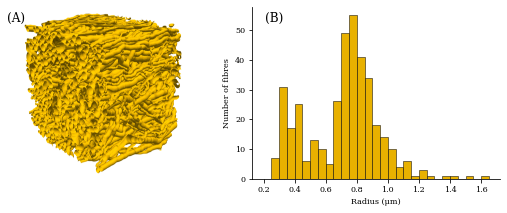

In [27]:
# Create the mesh figure

radii = np.loadtxt('ConFiG/mean_rad.txt')
img = np.array(PIL.Image.open('../LaTeX/Figures/config_mesh.png'))

fig, ax = plt.subplots(1, 2, figsize=(two_column, 3))
ax[0].imshow(img)
ax[0].axis('off')
hs = ax[1].hist(radii, edgecolor='black', color=(233/256, 178/256, 0),
                bins=np.arange(4, 34) / 20, linewidth=.5)
ax[1].set_xlabel('Radius (μm)')
ax[1].set_ylabel('Number of fibres')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].text(-0.05, .975, '(A)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           transform=ax[0].transAxes)
ax[1].text(0.05, .975, '(B)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           fontdict={'family' : 'serif'}, transform=ax[1].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/mesh_figure.pdf', dpi=dpi)

/home/leevi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


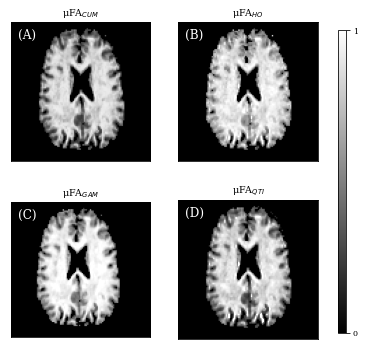

In [31]:
# Create the μFA maps figure

vol_cum_uFA = np.zeros((3, 128, 128, 60))
vol_ho_uFA = np.zeros((3, 128, 128, 60))
vol_gam_uFA = np.zeros((3, 128, 128, 60))
vol_qti_uFA = np.zeros((3, 128, 128, 60))
vol_mask = np.zeros((3, 128, 128, 60))

for i in range(3):
    vol_cum_uFA[i] = nib.load(
        '../Results/Volunteer-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_ho_uFA[i] = nib.load(
        '../Results/Volunteer-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_gam_uFA[i] = nib.load(
        '../Results/Volunteer-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_qti_uFA[i] = nib.load(
        '../Results/Volunteer-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()
    vol_mask[i] = nib.load(
        '../Preproc-data/Volunteer-%s/mask.nii.gz' % (i + 1)).get_fdata()

for _ in range(2):
    for i in range(3):
        vol_mask[i] = erosion(vol_mask[i])  # Exclude voxels near the skull
vol_mask = vol_mask.astype(bool)

MD = np.zeros((3, 128, 128, 60))
for i in range(3):
    MD[i] = nib.load(
        '../Results/Volunteer-%s/cum_MD.nii.gz' % (i + 1)).get_fdata()
vol_mask *= (MD < 2.5)  # CSF masking

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan
vol_cum_uFA[np.isnan(vol_cum_uFA)] = 0
vol_ho_uFA[np.isnan(vol_ho_uFA)] = 0
vol_gam_uFA[np.isnan(vol_gam_uFA)] = 0
vol_qti_uFA[np.isnan(vol_qti_uFA)] = 0

k = 33
vmin = 0
vmax = 1
fig, ax = plt.subplots(2, 2, figsize=(one_half_column, 6))
ax[0, 0].imshow(np.rot90(vol_cum_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
ax[0, 1].imshow(np.rot90(vol_ho_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
ax[1, 0].imshow(np.rot90(vol_gam_uFA[0, 15:-10, 14:-14, k]), vmin=vmin,
                vmax=vmax, cmap='gray')
im = ax[1, 1].imshow(np.rot90(vol_qti_uFA[0, 14:-14, 14:-14, k]), vmin=vmin,
                     vmax=vmax, cmap='gray')
labels = ['(A)', '(B)', '(C)', '(D)']
titles = ['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$', 'μFA$_{QTI}$']
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, .7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmax])
cbar.set_ticks([vmin, vmax])
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k = i * 2 + j
        ax[i,j].text(.05, .95, labels[k], verticalalignment='top',
                     horizontalalignment='left', fontsize=label_font_size,
                     color='white', transform=ax[i, j].transAxes)
        ax[i,j].set_title(titles[k])
plt.show()
fig.savefig('../LaTeX/Figures/uFA_maps.pdf', bbox_inches="tight", dpi=dpi)

In [32]:
# Quantify agreement between maps

def concordance_coefficient(x, y):
    """Calculate the concordance correlation coefficient."""
    x, y = x.ravel(), y.ravel()
    idx = ~np.isnan(x) * ~np.isnan(y)
    x, y = x[idx], y[idx]
    rho = (2 * np.cov(x, y)[0, 1] / 
           (np.var(x) + np.var(y) + (np.mean(x) - np.mean(y))**2))
    return rho

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan

print('Concordance coefficients:')
print('CUM-HO: %s' % concordance_coefficient(vol_cum_uFA, vol_ho_uFA))
print('CUM-GAM: %s' % concordance_coefficient(vol_cum_uFA, vol_gam_uFA))
print('CUM-QTI: %s' % concordance_coefficient(vol_cum_uFA, vol_qti_uFA))
print('HO-GAM: %s' % concordance_coefficient(vol_ho_uFA, vol_gam_uFA))
print('HO-QTI: %s' % concordance_coefficient(vol_ho_uFA, vol_qti_uFA))
print('GAM-QTI: %s' % concordance_coefficient(vol_gam_uFA, vol_qti_uFA))

Concordance coefficients:
CUM-HO: 0.6445340487150585
CUM-GAM: 0.8477803735455892
CUM-QTI: 0.9119017594982921
HO-GAM: 0.8532350727127096
HO-QTI: 0.6479523000051035
GAM-QTI: 0.808415684830049


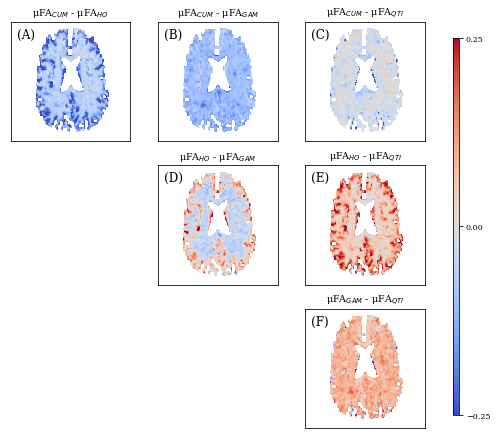

In [38]:
# Create the map comparison figure

k = 32
vmin = -.25
vmax = .25
cmap = 'coolwarm'

vol_cum_uFA[~vol_mask] = np.nan
vol_ho_uFA[~vol_mask] = np.nan
vol_gam_uFA[~vol_mask] = np.nan
vol_qti_uFA[~vol_mask] = np.nan

fig, ax = plt.subplots(3, 3, figsize=(two_column, two_column))
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_ho_uFA[0, 14:-14, 14:-14, k]
im = ax[0, 0].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 0].set_title('μFA$_{CUM}$ - μFA$_{HO}$')
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_gam_uFA[0, 14:-14, 14:-14, k]
ax[0, 1].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 1].set_title('μFA$_{CUM}$ - μFA$_{GAM}$')
diff = vol_cum_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[0, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[0, 2].set_title('μFA$_{CUM}$ - μFA$_{QTI}$')
diff = vol_ho_uFA[0, 14:-14, 14:-14, k] - vol_gam_uFA[0, 14:-14, 14:-14, k]
ax[1, 1].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1, 1].set_title('μFA$_{HO}$ - μFA$_{GAM}$')
diff = vol_ho_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[1, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[1, 2].set_title('μFA$_{HO}$ - μFA$_{QTI}$')
diff = vol_gam_uFA[0, 14:-14, 14:-14, k] - vol_qti_uFA[0, 14:-14, 14:-14, k]
ax[2, 2].imshow(np.rot90(diff), vmin=vmin, vmax=vmax, cmap=cmap)
ax[2, 2].set_title('μFA$_{GAM}$ - μFA$_{QTI}$')
for i in range(3):
    for j in range(3):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, .7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, 0, vmax])
ax[1,0].axis('off')
ax[2,0].axis('off')
ax[2,1].axis('off')
ax[0,0].text(.05, .95, '(A)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[0, 0].transAxes)
ax[0,1].text(.05, .95,'(B)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[0, 1].transAxes)
ax[0,2].text(.05, .95,'(C)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[0, 2].transAxes)
ax[1,1].text(.05, .95,'(D)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[1, 1].transAxes)
ax[1,2].text(.05, .95, '(E)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[1, 2].transAxes)
ax[2,2].text(.05, .95, '(F)', fontsize=label_font_size,
             verticalalignment='top', horizontalalignment='left',
             transform=ax[2, 2].transAxes)
plt.show()
fig.savefig('../LaTeX/Figures/uFA_maps_comparison.pdf', bbox_inches="tight",
            dpi=dpi)

Volunteer: R = 0.3654162638555144 (p = 0.0)
Phantom: R = 0.33661703268357857 (p = 3.1387053866660384e-17)


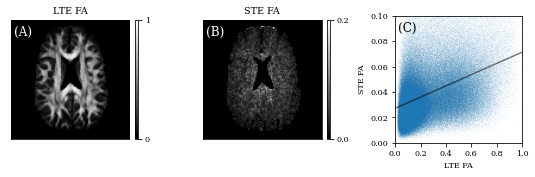

In [39]:
# Quantify orientational variance of the STE acquisition

lte_idx = np.arange(107)
ste_idx = np.arange(107, 214)

vol_data = np.zeros((3, 128, 128, 60, 214))
vol_bvals = np.zeros((3, 214))
vol_bvecs = np.zeros((3, 3, 214))
for i in range(3):
    vol_data[i] = nib.load(
        '../Preproc-data/Volunteer-%s/LTE-STE.nii.gz' % (i + 1)).get_fdata()
    vol_bvals[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bval' % (i + 1))
    vol_bvecs[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bvec' % (i + 1))
vol_lte_fa = np.zeros((3, 128, 128, 60)) 
vol_ste_fa = np.zeros((3, 128, 128, 60)) 
for i in range(3):
    gtab = gradient_table(vol_bvals[i, lte_idx], vol_bvecs[i, :, lte_idx])
    dtimodel = dti.TensorModel(gtab)
    dtifit = dtimodel.fit(vol_data[i, :, :, :, 0:107], mask=vol_mask[i])
    vol_lte_fa[i] = dtifit.fa
    gtab = gradient_table(vol_bvals[i, ste_idx], vol_bvecs[i, :, ste_idx])
    dtimodel = dti.TensorModel(gtab)
    dtifit = dtimodel.fit(vol_data[i, :, :, :, 107::], mask=vol_mask[i])
    vol_ste_fa[i] = dtifit.fa
vol_x, vol_y = vol_lte_fa[vol_mask].ravel(), vol_ste_fa[vol_mask].ravel()
idx = (vol_x != 0) * (vol_y != 0)
vol_x, vol_y = vol_x[idx], vol_y[idx]
print('Volunteer: R = %s (p = %s)' % scipy.stats.pearsonr(vol_x, vol_y))

ph_data = nib.load(
    '../Preproc-data/Phantom-avg/LTE-STE.nii.gz').get_fdata()
ph_bvals = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bval')
ph_bvecs = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bvec')
ph_mask = nib.load(
    '../Preproc-data/Phantom-avg/mask.nii.gz').get_fdata().astype(bool)
ph_lte_fa = np.zeros((128, 128, 10))
ph_ste_fa = np.zeros((128, 128, 10))
ph_gtab = gradient_table(ph_bvals[lte_idx], ph_bvecs[:, lte_idx])
dtimodel = dti.TensorModel(gtab)
dtifit = dtimodel.fit(ph_data[:, :, :, lte_idx], mask=ph_mask)
ph_lte_fa = dtifit.fa
gtab = gradient_table(ph_bvals[ste_idx], ph_bvecs[:, ste_idx])
dtimodel = dti.TensorModel(gtab)
dtifit = dtimodel.fit(ph_data[:, :, :, ste_idx], mask=ph_mask)
ph_ste_fa = dtifit.fa
ph_x, ph_y = ph_lte_fa.ravel(), ph_ste_fa.ravel()
idx = (ph_x != 0) * (ph_y != 0)
ph_x, ph_y = ph_x[idx], ph_y[idx]
print('Phantom: R = %s (p = %s)' % scipy.stats.pearsonr(ph_x, ph_y))

fig, ax = plt.subplots(1, 3, figsize=(two_column, two_column / 3))
k = 32
im = ax[0].imshow(np.rot90(vol_lte_fa[0, 14:-14, 14:-14, k]), vmin=0, vmax=1, cmap='gray')
divider = make_axes_locatable(ax[0])
cbar = plt.colorbar(im, cax=divider.append_axes("right", size="2.5%", pad=0.075))
cbar.set_ticks([0, 1])
im = ax[1].imshow(np.rot90(vol_ste_fa[0, 14:-14, 14:-14, k]), vmin=0, vmax=.2, cmap='gray')
divider = make_axes_locatable(ax[1])
cbar = plt.colorbar(im, cax=divider.append_axes("right", size="2.5%", pad=0.075))
cbar.set_ticks([0, .2])
for i, title in enumerate(['LTE FA', 'STE FA']):
    ax[i].set_title(title)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[2].scatter(vol_x, vol_y, s=.01, alpha=.1)
m, b = np.polyfit(vol_x, vol_y, 1)
ax[2].plot(np.array([0, 1]), m * np.array([0, 1]) + b, color='black', alpha=.5)
ax[2].set_xlim([0, 1])
ax[2].set_ylim([0, .1])
ax[2].set_xlabel('LTE FA')
ax[2].set_ylabel('STE FA')
ax[2].set_aspect(10)
ax[0].text(.025, .95, '(A)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='white',
           transform=ax[0].transAxes)
ax[1].text(.025, .95, '(B)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='white',
           transform=ax[1].transAxes)
ax[2].text(.025, .95, '(C)', verticalalignment='top',
           horizontalalignment='left', fontsize=label_font_size, color='black',
           transform=ax[2].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/FA_figure.png', bbox_inches="tight", dpi=dpi)

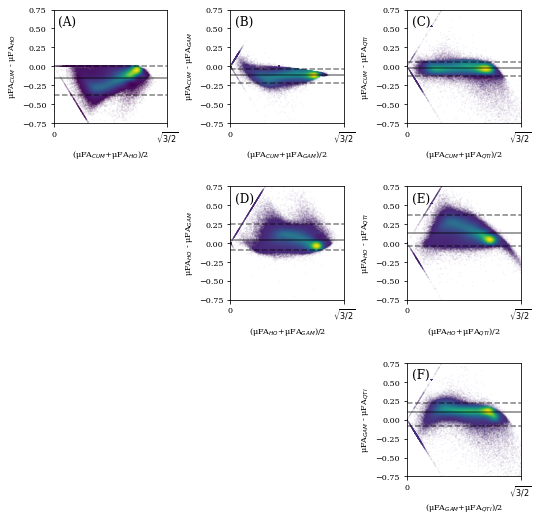

Mean uFA cumulant = 0.5931825676309105
Mean uFA higher order = 0.7512335297391125
Mean uFA gamma = 0.7094321443739268
Mean uFA QTI = 0.612815533356921

Cumulant vs higher order
Mean difference = -0.15805096210820183
ll, ul, width = -0.38060445791367714, -1.577035835254037e-09, 0.3806044563366413
LinregressResult(slope=0.259714716869342, intercept=-0.33263328514972246, rvalue=0.46478641109069463, pvalue=0.0, stderr=0.0007688316906456532)

Cumulant vs gamma
Mean difference = -0.11624957674301573
ll, ul, width = -0.21440533528128358, -0.032622794315754655, 0.18178254096552893
LinregressResult(slope=0.048273330389437395, intercept=-0.1476903519243914, rvalue=0.2116802110961248, pvalue=0.0, stderr=0.0003463455767767453)

Cumulant vs QTI
Mean difference = -0.019632965726010775
ll, ul, width = -0.1317096431307736, 0.05031215406146938, 0.18202179719224298
LinregressResult(slope=-0.0934268346183242, intercept=0.03670332683949082, rvalue=-0.2221000842041905, pvalue=0.0, stderr=0.0006373464667578

In [19]:
# Create the voxel-wise comparison figure

def density_scatter(x, y, ax, **kwargs):
    """Create a scatter plot where colour reflects point density."""
    data, x_e, y_e = np.histogram2d(
        x, y, range=[[0, np.sqrt(1.5)], [-np.sqrt(1.5), np.sqrt(1.5)]], bins=30,
        density=True)
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data,
                 np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, **kwargs)
    return

fig, ax = plt.subplots(3, 3, figsize=(two_column, two_column))

y1 = vol_cum_uFA.ravel() - vol_ho_uFA.ravel()
x1 = (vol_cum_uFA.ravel() + vol_ho_uFA.ravel()) / 2
idx = ~np.isnan(x1 * y1)
x1, y1 = x1[idx], y1[idx]
a1 = vol_cum_uFA.ravel()[idx]
b1 = vol_ho_uFA.ravel()[idx]
ll1 = np.percentile(y1, 2.5)
ul1 = np.percentile(y1, 97.5)
ax[0,0].plot([0, np.sqrt(1.5)], [np.mean(y1), np.mean(y1)], color='black',
             alpha=.5)
ax[0,0].plot([0, np.sqrt(1.5)], [ul1, ul1], ls='--', color='black', alpha=.5)
ax[0,0].plot([0, np.sqrt(1.5)], [ll1, ll1], ls='--', color='black', alpha=.5)
density_scatter(x1, y1, ax=ax[0,0], s=.01, alpha=.25)
ax[0,0].set_ylabel('μFA$_{CUM}$ - μFA$_{HO}$')
ax[0,0].set_xlabel('(μFA$_{CUM}$+μFA$_{HO}$)/2')

y2 = vol_cum_uFA.ravel() - vol_gam_uFA.ravel()
x2 = (vol_cum_uFA.ravel() + vol_gam_uFA.ravel()) / 2
idx = ~np.isnan(x2 * y2)
x2, y2 = x2[idx], y2[idx]
a2 = vol_cum_uFA.ravel()[idx]
b2 = vol_gam_uFA.ravel()[idx]
ll2 = np.percentile(y2, 2.5)
ul2 = np.percentile(y2, 97.5)
ax[0,1].plot([0, np.sqrt(1.5)], [np.mean(y2), np.mean(y2)], color='black',
             alpha=.5)
ax[0,1].plot([0, np.sqrt(1.5)], [ul2, ul2], ls='--', color='black', alpha=.5)
ax[0,1].plot([0, np.sqrt(1.5)], [ll2, ll2], ls='--', color='black', alpha=.5)
density_scatter(x2, y2, ax=ax[0,1], s=.01, alpha=.25)
ax[0,1].set_ylabel('μFA$_{CUM}$ - μFA$_{GAM}$')
ax[0,1].set_xlabel('(μFA$_{CUM}$+μFA$_{GAM}$)/2')

y3 = vol_cum_uFA.ravel() - vol_qti_uFA.ravel()
x3 = (vol_cum_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x3 * y3)
x3, y3 = x3[idx], y3[idx]
a3 = vol_cum_uFA.ravel()[idx]
b3 = vol_qti_uFA.ravel()[idx]
ll3 = np.percentile(y3, 2.5)
ul3 = np.percentile(y3, 97.5)
ax[0,2].plot([0, np.sqrt(1.5)], [np.mean(y3), np.mean(y3)], color='black',
             alpha=.5)
ax[0,2].plot([0, np.sqrt(1.5)], [ul3, ul3], ls='--', color='black', alpha=.5)
ax[0,2].plot([0, np.sqrt(1.5)], [ll3, ll3], ls='--', color='black', alpha=.5)
density_scatter(x3, y3, ax=ax[0,2], s=.01, alpha=.25)
ax[0,2].set_ylabel('μFA$_{CUM}$ - μFA$_{QTI}$')
ax[0,2].set_xlabel('(μFA$_{CUM}$+μFA$_{QTI}$)/2')

y4 = vol_ho_uFA.ravel() - vol_gam_uFA.ravel()
x4 = (vol_ho_uFA.ravel() + vol_gam_uFA.ravel()) / 2
idx = ~np.isnan(x4 * y4)
x4, y4 = x4[idx], y4[idx]
a4 = vol_ho_uFA.ravel()[idx]
b4 = vol_gam_uFA.ravel()[idx]
ll4 = np.percentile(y4, 2.5)
ul4 = np.percentile(y4, 97.5)
ax[1,1].plot([0, np.sqrt(1.5)], [np.mean(y4), np.mean(y4)], color='black',
             alpha=.5)
ax[1,1].plot([0, np.sqrt(1.5)], [ul4, ul4], ls='--', color='black', alpha=.5)
ax[1,1].plot([0, np.sqrt(1.5)], [ll4, ll4], ls='--', color='black', alpha=.5)
density_scatter(x4, y4, ax=ax[1,1], s=.01, alpha=.25)
ax[1,1].set_ylabel('μFA$_{HO}$ - μFA$_{GAM}$')
ax[1,1].set_xlabel('(μFA$_{HO}$+μFA$_{GAM}$)/2')

y5 = vol_ho_uFA.ravel() - vol_qti_uFA.ravel()
x5 = (vol_ho_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x5 * y5)
x5, y5 = x5[idx], y5[idx]
a5 = vol_ho_uFA.ravel()[idx]
b5 = vol_qti_uFA.ravel()[idx]
ll5 = np.percentile(y5, 2.5)
ul5 = np.percentile(y5, 97.5)
ax[1,2].plot([0, np.sqrt(1.5)], [np.mean(y5), np.mean(y5)], color='black',
             alpha=.5)
ax[1,2].plot([0, np.sqrt(1.5)], [ul5, ul5], ls='--', color='black', alpha=.5)
ax[1,2].plot([0, np.sqrt(1.5)], [ll5, ll5], ls='--', color='black', alpha=.5)
density_scatter(x5, y5, ax=ax[1,2], s=.01, alpha=.25)
ax[1,2].set_ylabel('μFA$_{HO}$ - μFA$_{QTI}$')
ax[1,2].set_xlabel('(μFA$_{HO}$+μFA$_{QTI}$)/2')

y6 = vol_gam_uFA.ravel() - vol_qti_uFA.ravel()
x6 = (vol_gam_uFA.ravel() + vol_qti_uFA.ravel()) / 2
idx = ~np.isnan(x6 * y6)
x6, y6 = x6[idx], y6[idx]
a6 = vol_gam_uFA.ravel()[idx]
b6 = vol_qti_uFA.ravel()[idx]
ll6 = np.percentile(y6, 2.5)
ul6 = np.percentile(y6, 97.5)
ax[2,2].plot([0, np.sqrt(1.5)], [np.mean(y6), np.mean(y6)], color='black',
             alpha=.5)
ax[2,2].plot([0, np.sqrt(1.5)], [ul6, ul6], ls='--', color='black', alpha=.5)
ax[2,2].plot([0, np.sqrt(1.5)], [ll6, ll6], ls='--', color='black', alpha=.5)
density_scatter(x6, y6, ax=ax[2,2], s=.01, alpha=.25)
ax[2,2].set_ylabel('μFA$_{GAM}$ - μFA$_{QTI}$')
ax[2,2].set_xlabel('(μFA$_{GAM}$+μFA$_{QTI}$)/2')

for i in range(3):
    for j in range(i, 3):
        #ax[i,j].plot([0, np.sqrt(1.5)], [0, 0], ls=':', color='black')
        ax[i,j].set_aspect(np.sqrt(1.5) / 1.5)
        ax[i,j].set_xlim([0, np.sqrt(1.5)])
        ax[i,j].set_ylim([-.75, .75])
        ax[i,j].set_xticks([0, np.sqrt(1.5)])
        ax[i,j].set_yticks([-.75, -.5, -.25, 0, .25, .5, .75])
        ax[i,j].set_xticklabels(['0', '$\sqrt{3/2}$'])
ax[1,0].axis('off')
ax[2,0].axis('off')
ax[2,1].axis('off')
ax[0,0].text(.05, .675, '(A)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')
ax[0,1].text(.05, .675,'(B)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')
ax[0,2].text(.05, .675,'(C)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')
ax[1,1].text(.05, .675,'(D)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')
ax[1,2].text(.05, .675, '(E)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')
ax[2,2].text(.05, .675, '(F)', fontsize=label_font_size, verticalalignment='top',
             horizontalalignment='left')

fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/ba_plots.png', dpi=dpi)

print('Mean uFA cumulant = %s' % np.nanmean(vol_cum_uFA))
print('Mean uFA higher order = %s' % np.nanmean(vol_ho_uFA))
print('Mean uFA gamma = %s' % np.nanmean(vol_gam_uFA))
print('Mean uFA QTI = %s' % np.nanmean(vol_qti_uFA))
print('')
print('Cumulant vs higher order')
print('Mean difference = %s' % np.mean(y1))
print('ll, ul, width = %s, %s, %s' % (ll1, ul1, abs(ll1 - ul1)))
print(scipy.stats.linregress(x1, y1))
print('')
print('Cumulant vs gamma')
print('Mean difference = %s' % np.mean(y2))
print('ll, ul, width = %s, %s, %s' % (ll2, ul2, abs(ll2 - ul2)))
print(scipy.stats.linregress(x2, y2))
print('')
print('Cumulant vs QTI')
print('Mean difference = %s' % np.mean(y3))
print('ll, ul, width = %s, %s, %s' % (ll3, ul3, abs(ll3 - ul3)))
print(scipy.stats.linregress(x3, y3))
print('')
print('Higher order vs gamma')
print('Mean difference = %s' % np.mean(y4))
print('ll, ul, width = %s, %s, %s' % (ll4, ul4, abs(ll4 - ul4)))
print(scipy.stats.linregress(x4, y4))
print('')
print('Higher order vs QTI')
print('Mean difference = %s' % np.mean(y5))
print('ll, ul, width = %s, %s, %s' % (ll5, ul5, abs(ll5 - ul5)))
print(scipy.stats.linregress(x5, y5))
print('')
print('Gamma vs QTI')
print('Mean difference = %s' % np.mean(y6))
print('ll, ul, width = %s, %s, %s' % (ll6, ul6, abs(ll6 - ul6)))
print(scipy.stats.linregress(x6, y6))

In [45]:
ph_cum_uFA[ROI_para].shape

(35, 11)

Ttest_indResult(statistic=-72.6811590796737, pvalue=1.0284803856715304e-25)
Ttest_indResult(statistic=-152.93239825280426, pvalue=3.653971510854389e-32)
Ttest_indResult(statistic=9.93004001881741, pvalue=3.5597627953710313e-09)
Ttest_indResult(statistic=-34.03800860798366, pvalue=3.516106598581618e-19)
Ttest_indResult(statistic=81.04659469006165, pvalue=1.1721950326860321e-26)
Ttest_indResult(statistic=167.07107947444914, pvalue=6.24171199656892e-33)
Ttest_indResult(statistic=-23.29886278629719, pvalue=5.749156760496023e-16)
Ttest_indResult(statistic=-59.20648348981021, pvalue=6.099973733901663e-24)
Ttest_indResult(statistic=13.474684859891855, pvalue=1.7086070824034617e-11)
Ttest_indResult(statistic=-16.27327851394833, pvalue=5.307992796125045e-13)
Ttest_indResult(statistic=34.27462951477602, pvalue=3.0680163176586946e-19)
Ttest_indResult(statistic=92.5113729371719, pvalue=8.369887657871388e-28)
Ttest_indResult(statistic=-44.88886887200698, pvalue=1.4879244481779668e-21)
Ttest_indResu

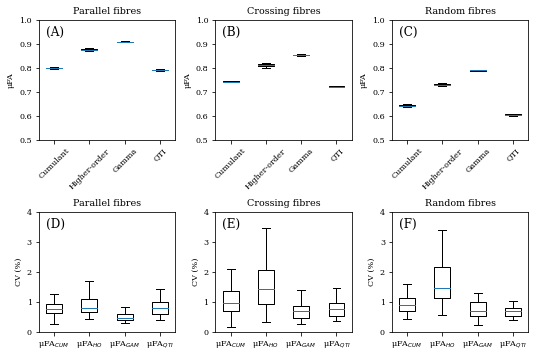

In [46]:
# Create the phantom figure

ph_cum_uFA = np.zeros((128, 128, 10, 11))
ph_ho_uFA = np.zeros((128, 128, 10, 11))
ph_gam_uFA = np.zeros((128, 128, 10, 11))
ph_qti_uFA = np.zeros((128, 128, 10, 11))

for i in range(11):
    ph_cum_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_ho_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_gam_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    ph_qti_uFA[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()
ROI_para = nib.load(
    '../Preproc-data/phantom_para_mask.nii.gz').get_fdata().astype(bool)
ROI_cros = nib.load(
    '../Preproc-data/phantom_cros_mask.nii.gz').get_fdata().astype(bool)
ROI_rand = nib.load(
    '../Preproc-data/phantom_rand_mask.nii.gz').get_fdata().astype(bool)
ph_mask = nib.load(
    '../Preproc-data/Phantom-avg/mask.nii.gz').get_fdata().astype(bool)

fig, ax = plt.subplots(2, 3, figsize=(two_column, 5))
pos = [0, .7, 1.4, 2.1]
mu = .25 * (np.mean(ph_cum_uFA[ph_mask])
            + np.mean(ph_ho_uFA[ph_mask])
            + np.mean(ph_gam_uFA[ph_mask])
            + np.mean(ph_qti_uFA[ph_mask]))
for i, roi in enumerate([ROI_para, ROI_cros, ROI_rand]):
    #ax[0, i].bar(x=pos, height=[np.mean(ph_cum_uFA[roi]),
    #                            np.mean(ph_ho_uFA[roi]),
    #                            np.mean(ph_gam_uFA[roi]),
    #                            np.mean(ph_qti_uFA[roi])],
    #             yerr=[np.std(np.mean(ph_cum_uFA[roi], axis=0)),
    #                   np.std(np.mean(ph_ho_uFA[roi], axis=0)),
    #                   np.std(np.mean(ph_gam_uFA[roi], axis=0)),
    #                   np.std(np.mean(ph_qti_uFA[roi], axis=0))], width=.25)
    ax[0, i].boxplot([np.mean(ph_cum_uFA[roi], axis=0),
                      np.mean(ph_ho_uFA[roi], axis=0),
                      np.mean(ph_gam_uFA[roi], axis=0),
                      np.mean(ph_qti_uFA[roi], axis=0)],
                     positions=pos,
                     medianprops={'color' : 'tab:blue'},
                     showfliers=False)
    ax[1, i].boxplot([100 * np.std(ph_cum_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_ho_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_gam_uFA[roi], axis=1) / mu,
                      100 * np.std(ph_qti_uFA[roi], axis=1) / mu],
                     positions=pos,
                     medianprops={'color' : 'tab:blue'},
                     showfliers=False)
    ax[0, i].set_ylim([.5, 1])
    ax[0, i].set_ylabel('μFA')
    ax[1, i].set_ylim([0, 4])
    ax[1, i].set_ylabel('CV (%)')
    print(scipy.stats.ttest_ind(np.mean(ph_cum_uFA[roi], axis=0),
                                np.mean(ph_ho_uFA[roi], axis=0)))
    print(scipy.stats.ttest_ind(np.mean(ph_cum_uFA[roi], axis=0),
                                np.mean(ph_gam_uFA[roi], axis=0)))
    print(scipy.stats.ttest_ind(np.mean(ph_cum_uFA[roi], axis=0),
                                np.mean(ph_qti_uFA[roi], axis=0)))
    print(scipy.stats.ttest_ind(np.mean(ph_ho_uFA[roi], axis=0),
                                np.mean(ph_gam_uFA[roi], axis=0)))
    print(scipy.stats.ttest_ind(np.mean(ph_ho_uFA[roi], axis=0),
                                np.mean(ph_qti_uFA[roi], axis=0)))
    print(scipy.stats.ttest_ind(np.mean(ph_gam_uFA[roi], axis=0),
                                np.mean(ph_qti_uFA[roi], axis=0)))

titles = ['Parallel fibres', 'Crossing fibres', 'Random fibres']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']
for i in range(2):
    for j in range(3):
        ax[i, j].set_title(titles[j])
        ax[i, j].set_xticks(pos)
        ax[i, j].set_xlim([-.3, 2.4])
        k = i * 3 + j
        ax[i, j].text(0.05, 0.95, labels[k], verticalalignment='top',
                      horizontalalignment='left', transform=ax[i, j].transAxes,
                      size=label_font_size)
        ax[0, j].set_xticklabels(['Cumulant', 'Higher-order', 'Gamma', 'QTI'],
                                 rotation=45)
        ax[1, j].set_xticklabels(['μFA$_{CUM}$',
                                  'μFA$_{HO}$',
                                  'μFA$_{GAM}$',
                                  'μFA$_{QTI}$'])
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/phantom.pdf')

In [ ]:
# Create the simulation figure

path = '../Preproc-data'
signals = np.zeros((3, 382, 214))
for i in range(3):
    temp_signals = np.load(os.path.join(path,
                                        'simulated_signals_%s.npy' % (i + 1)))
    for j in range(381):  # Intra-axonal
        signals[i, j + 1] = np.nanmean(
            temp_signals[:, int(j*1e3):int((j+1)*1e3)], axis=1)
    signals[i, 0] = np.nanmean(
        temp_signals[:, int(381e3)::], axis=1)  # Extra-axonal
total_signals = np.zeros((3, 3, 214))
fs_ic = [.2, .6, 1]  # Intra-axonal signal fractions
weights = np.zeros((3, 382))
for i in range(3):
    for j, w in enumerate(fs_ic):
        weights[j] = np.ones(382) * w / 381
        weights[j, 0] = 1 - w
        total_signals[i, j] = np.sum(weights[j, :, np.newaxis] * signals[i],
                                     axis=0)

gt_uFA = np.zeros((3, 3))  # Ground-truth values
lte_idx = np.arange(0, 107).astype(int)
ste_idx = np.arange(107, 214).astype(int)
bvals = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bval')[0:107] / 1e3
bvals = np.concatenate([bvals, bvals])
bs = np.unique(bvals)
bvecs = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bvec')[:, 0:107].T
bvecs = np.concatenate([bvecs, bvecs], axis=0)
gtab = gradient_table(bvals[lte_idx], bvecs[lte_idx])
dki_model = dki.DiffusionKurtosisModel(gtab)
for i in range(3):
    for j in range(3):
        evals = np.zeros((382, 3))
        for k in range(382):
            evals[k] = dki_model.fit(signals[i, k, lte_idx]).evals
        avg_eval_var = np.sum(weights[j] * np.var(evals, axis=1))
        avg_md_sq = np.sum(weights[j] * np.mean(evals, axis=1)**2)
        gt_uFA[i, j] = np.sqrt(1.5 * avg_eval_var / (avg_eval_var + avg_md_sq))

import cumulant
import higher_order
import gamma
import qti

def fit_uFAs(signals):
    pa_lte = gamma.calc_pa(signals[lte_idx], bvals[lte_idx])
    pa_ste = gamma.calc_pa(signals[ste_idx], bvals[ste_idx])
    x = cumulant.fit_cum_model(pa_lte, pa_ste, np.unique(bvals))
    cum_uFA = cumulant.calc_uFA(x[1], x[3], x[2])
    x = higher_order.fit_ho_model(pa_lte, pa_ste, np.unique(bvals))
    ho_uFA = higher_order.calc_uFA(x[1], x[3], x[2])
    x = gamma.fit_gamma_model(pa_lte, pa_ste, np.unique(bvals))
    gam_uFA = gamma.calc_uFA(x[1], x[3], x[2])
    X = qti.calc_design_matrix(bvecs[lte_idx], bvals[lte_idx],
                               bvecs[ste_idx], bvals[ste_idx])
    S0_hat, D_hat, C_hat = qti.fit_qti(
        np.concatenate([signals[lte_idx], signals[ste_idx]]), X)
    qti_uFA = qti.calc_uFA(D_hat, C_hat)   
    return cum_uFA, ho_uFA, gam_uFA, qti_uFA

SNR = 25
N = int(1e4)
sim_cum_uFA = np.zeros((3, 3, N))
sim_gam_uFA = np.zeros((3, 3, N))
sim_ho_uFA = np.zeros((3, 3, N))
sim_qti_uFA = np.zeros((3, 3, N))
for i in range(3):
    for j in range(3):
        for k in range(N):
            print('%s/%s' % (i * (3 * N) + j * N + k, N * 3 * 3), end='\r')
            sigma = np.max(total_signals[i, j]) / SNR
            noisy_signals = np.abs(
                total_signals[i, j] + np.random.normal(
                    size=total_signals[i, j].shape, scale=sigma, loc=0)
                + 1j * np.random.normal(size=total_signals[i, j].shape,
                                        scale=sigma, loc=0))
            (sim_cum_uFA[i, j, k], sim_ho_uFA[i, j, k], sim_gam_uFA[i, j, k],
             sim_qti_uFA[i ,j, k]) = fit_uFAs(noisy_signals * 1e3)
            
    
# Create figure and print results

fig, ax = plt.subplots(3, 3, figsize=(two_column, 9))
pos = [0, .7, 1.4, 2.1]
for i in range(3):
    for j in range(3):
        ax[i, j].boxplot([sim_cum_uFA[i, j], sim_ho_uFA[i, j],
                          sim_gam_uFA[i, j], 
                          sim_qti_uFA[i, j][~np.isnan(sim_qti_uFA[i, j])]],
                         positions=pos, medianprops = {'color' : 'tab:blue'},
                         showfliers=False)
        ax[i, j].plot([-.5, 2.5], [gt_uFA[i, j], gt_uFA[i, j]], ls='--',
                      color='black', lw=1, alpha=.5)
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)']
encoding = ['Simulation 1 (QTE)', 'Simulation 2 (TDE1)', 'Simulation 3 (TDE2)']
for i in range(3):
    for j in range(3):
        k = i * 3 + j
        ax[i,j].set_xlim([-.35, 2.45])
        ax[i,j].set_yticks(np.concatenate([np.linspace(0, 1, 5),
                                           [np.sqrt(1.5)]]))
        ax[i,j].set_yticklabels(['0', '0.25', '0.5', '0.75', '1',
                                 '$\sqrt{3/2}$'])
        ax[i,j].set_xticks(pos)
        ax[i,j].set_xticklabels(['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$',
                               'μFA$_{QTI}$'])
        ax[i, j].set_title('f$_{intra}$ = %s' % fs_ic[j])
        ax[i, j].text(0.05, 0.95, labels[k], verticalalignment='top',
                      horizontalalignment='left', fontsize=label_font_size,
                      transform=ax[i, j].transAxes)
    ax[i, 0].text(-0.3, 0.5, encoding[i], verticalalignment='center',
                  horizontalalignment='center', fontsize=label_font_size,
                  rotation=90, transform=ax[i, 0].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/sim_results.pdf', dpi=dpi)

print('\nGround truth ranges from %s to %s' % (np.min(gt_uFA), np.max(gt_uFA)))
print('\nCumulant MSE: %s' % np.mean(
    (np.mean(sim_cum_uFA, axis=2)[2] - gt_uFA[2])**2))
print('Higher order MSE: %s' % np.mean(
    (np.mean(sim_ho_uFA, axis=2)[2] - gt_uFA[2])**2))
print('Gamma MSE: %s' % np.mean(
    (np.mean(sim_gam_uFA, axis=2)[2] - gt_uFA[2])**2))
print('QTI MSE: %s' % np.mean(
    (np.nanmean(sim_qti_uFA, axis=2)[2] - gt_uFA[2])**2))
print('\nBias caused by time-dependent diffusion:')
print(np.nanmean(sim_cum_uFA, axis=2)[0] - np.nanmean(sim_cum_uFA, axis=2)[2])
print(np.nanmean(sim_ho_uFA, axis=2)[0] - np.nanmean(sim_ho_uFA, axis=2)[2])
print(np.nanmean(sim_gam_uFA, axis=2)[0] - np.nanmean(sim_gam_uFA, axis=2)[2])
print(np.nanmean(sim_qti_uFA, axis=2)[0] - np.nanmean(sim_qti_uFA, axis=2)[2])
print('\nStandard deviations:')
print(np.std(sim_cum_uFA, axis=2))
print(np.std(sim_ho_uFA, axis=2))
print(np.std(sim_gam_uFA, axis=2))
print(np.nanstd(sim_qti_uFA, axis=2))
print('\nCVs:')
print(np.mean(np.std(sim_cum_uFA, axis=2)) / np.mean(gt_uFA) * 100)
print(np.mean(np.std(sim_ho_uFA, axis=2)) / np.mean(gt_uFA) * 100)
print(np.mean(np.std(sim_gam_uFA, axis=2)) / np.mean(gt_uFA) * 100)
print(np.mean(np.nanstd(sim_qti_uFA, axis=2)) / np.mean(gt_uFA) * 100)

/home/leevi/Dropbox/PhD/QTE/Publication/Code/qti.py:133: RuntimeWarning: invalid value encountered in sqrt
  from_6x6_to_21x1(E_iso)))
